<a href="https://colab.research.google.com/github/kjhaveri2321/Anomaly-Detection-in-Network-Traffic/blob/main/KrishJhaveri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Installing and Importing Required Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold




#Loading the 10% KDDCup99 Dataset
Load and inspect the dataset

In [ ]:
# Load 10% dataset from UCI repository
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"

# Define column names
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "Target"
]

# Load dataset
df = pd.read_csv(url, names=column_names, compression="gzip")

# Convert target variable to binary (0 = Normal, 1 = Attack)
df["Target"] = df["Target"].apply(lambda x: 0 if x == "normal." else 1)

# Display dataset shape
print("Dataset Shape:", df.shape)
df.head()



Dataset Shape: (494021, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Target
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


#1. Data Preprocessing

##1.1  Handling Missing Values :
Identify and appropriately address any missing or inconsistent data entries.

In [ ]:
# Check missing values
print("Total Missing Values:", df.isnull().sum().sum())

# Fill missing values (if any)
df.fillna(df.median(numeric_only=True), inplace=True)


Total Missing Values: 0


## 1.2 Categorical Encoding :
Convert categorical features (e.g., protocol type, service) into
numerical representations.

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Identify categorical columns
categorical_cols = ["protocol_type", "service", "flag"]

# Apply Label Encoding to categorical features
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

print(f"Categorical Encoding Applied: {categorical_cols}")
print(df[categorical_cols].head())  # Display encoded columns

#Fitted Label Encoders
encoder_protocol = LabelEncoder().fit(df['protocol_type'])
encoder_service = LabelEncoder().fit(df['service'])
encoder_flag = LabelEncoder().fit(df['flag'])

Categorical Encoding Applied: ['protocol_type', 'service', 'flag']
   protocol_type  service  flag
0              1       22     9
1              1       22     9
2              1       22     9
3              1       22     9
4              1       22     9


##1.3 Remove Low-Variance Features

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Apply variance threshold (removes features with variance < 0.01)
selector = VarianceThreshold(threshold=0.01)
X = df.drop(columns=["Target"])
X_low_var = selector.fit_transform(X)

# Get the remaining feature names
selected_features = X.columns[selector.get_support()]

# Get the dropped (low variance) feature names
low_variance_features = X.columns[~selector.get_support()].tolist()

# Convert back to DataFrame with only selected features
X = pd.DataFrame(X_low_var, columns=selected_features)

print(f"Removed {len(low_variance_features)} low-variance features: {low_variance_features}")



Removed 13 low-variance features: ['land', 'urgent', 'num_failed_logins', 'root_shell', 'su_attempted', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'diff_srv_rate', 'dst_host_srv_diff_host_rate']


##1.4 Remove Highly Correlated Features

In [ ]:
import numpy as np

# Compute correlation matrix
corr_matrix = X.corr().abs()

# Identify highly correlated features (correlation > 0.8)
high_corr_pairs = np.where(corr_matrix > 0.8)
high_corr_features = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_pairs) if x != y]

# Identify unique features to drop
features_to_drop = set()
for feature1, feature2 in high_corr_features:
    if feature1 not in features_to_drop and feature2 not in features_to_drop:
        features_to_drop.add(feature2)  # Keep feature1, drop feature2

# Drop correlated features
X = X.drop(columns=features_to_drop)

print(f"Removed {len(features_to_drop)} highly correlated features: {features_to_drop}")

# **Recompute the correlation matrix AFTER dropping features**
corr_matrix_after = X.corr().abs()
print("\nUpdated Correlation Matrix (Top 10 Features):")
print(corr_matrix_after.iloc[:10, :10])  # Show top correlations after removal

high_corr_features = sorted(list(features_to_drop))


Removed 13 highly correlated features: {'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_same_srv_rate', 'same_srv_rate', 'srv_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate', 'num_root', 'dst_host_serror_rate', 'srv_count', 'dst_host_same_src_port_rate', 'count', 'dst_host_srv_count'}

Updated Correlation Matrix (Top 10 Features):
                 duration  protocol_type   service      flag  src_bytes  \
duration         1.000000       0.163251  0.078995  0.019739   0.004258   
protocol_type    0.163251       1.000000  0.741244  0.476091   0.001904   
service          0.078995       0.741244  1.000000  0.725525   0.001206   
flag             0.019739       0.476091  0.725525  1.000000   0.002880   
src_bytes        0.004258       0.001904  0.001206  0.002880   1.000000   
dst_bytes        0.005440       0.024519  0.006135  0.013191   0.000002   
wrong_fragment   0.003235       0.113568  0.067200  0.024541   0.000139   
hot              0.013213       0.040859 

## 1.5 Feature Scaling
Normalize or standardize numerical features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Apply MinMax Scaling to normalize all numerical features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("Feature scaling applied using MinMaxScaler.")

# Display the first few rows of the scaled dataset
print("\nScaled Dataset (First 5 Rows):")
print(X_scaled.head())

#scaler = MinMaxScaler().fit(X_train_unscaled)
# If you need to store the scaler, you can simply keep the 'scaler' variable
# as it is already fitted.

# If you need to scale another dataset later (like X_train), you can use:
# X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

Feature scaling applied using MinMaxScaler.

Scaled Dataset (First 5 Rows):
   duration  protocol_type   service  flag     src_bytes  dst_bytes  \
0       0.0            0.5  0.338462   0.9  2.610418e-07   0.001057   
1       0.0            0.5  0.338462   0.9  3.446905e-07   0.000094   
2       0.0            0.5  0.338462   0.9  3.389216e-07   0.000259   
3       0.0            0.5  0.338462   0.9  3.158461e-07   0.000259   
4       0.0            0.5  0.338462   0.9  3.129617e-07   0.000394   

   wrong_fragment  hot  logged_in  num_compromised  serror_rate  rerror_rate  \
0             0.0  0.0        1.0              0.0          0.0          0.0   
1             0.0  0.0        1.0              0.0          0.0          0.0   
2             0.0  0.0        1.0              0.0          0.0          0.0   
3             0.0  0.0        1.0              0.0          0.0          0.0   
4             0.0  0.0        1.0              0.0          0.0          0.0   

   srv_diff_host

##1.6 Check Class Distribution

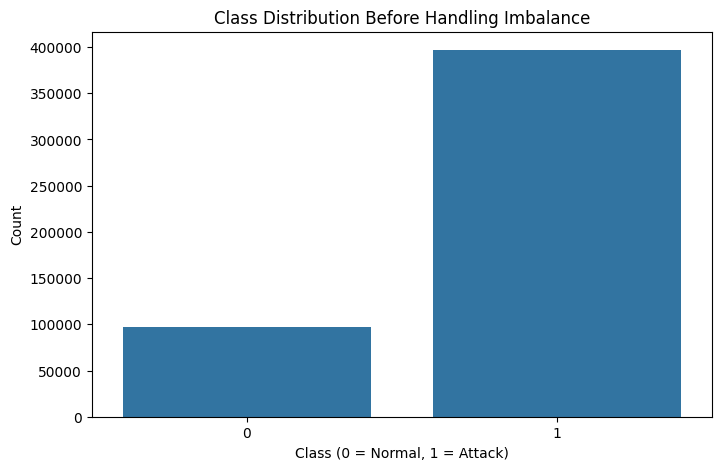

Class 0 (Normal): 97278
Class 1 (Attack): 396743


In [ ]:
# Plot class distribution before applying balancing techniques
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Target"])
plt.title("Class Distribution Before Handling Imbalance")
plt.xlabel("Class (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.show()

# Print class counts
class_counts = df["Target"].value_counts()
print(f"Class 0 (Normal): {class_counts[0]}")
print(f"Class 1 (Attack): {class_counts[1]}")


### Visualizing Feature-Target Correlations


Top Feature-Target Correlations AFTER Cleaning:
logged_in                 0.795282
dst_host_count            0.642110
protocol_type             0.616601
srv_diff_host_rate        0.364687
serror_rate               0.227739
flag                      0.155672
service                   0.131723
duration                  0.118014
dst_host_diff_srv_rate    0.115901
dst_bytes                 0.037709
dtype: float64


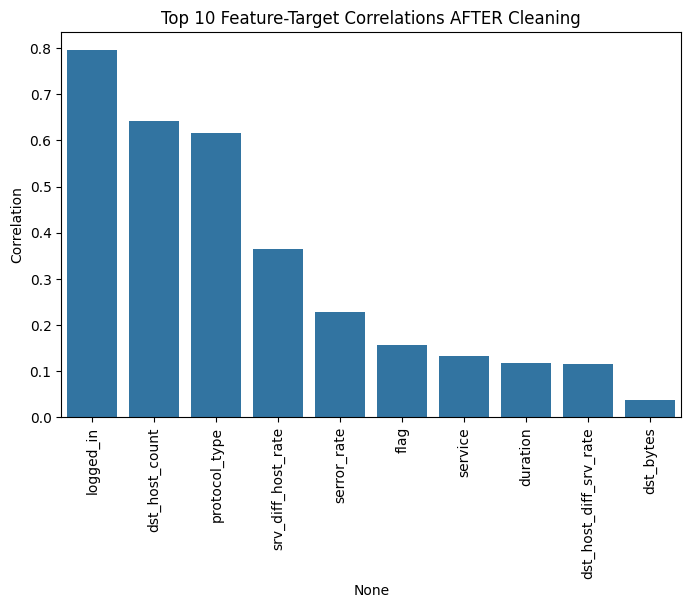

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation **AFTER** removing highly correlated features
correlation_after = X.corrwith(df["Target"]).abs().sort_values(ascending=False)

# Display top correlated features after cleaning
print("\nTop Feature-Target Correlations AFTER Cleaning:")
print(correlation_after.head(10))

# Visualize updated correlations
plt.figure(figsize=(8, 5))
sns.barplot(x=correlation_after.head(10).index, y=correlation_after.head(10).values)
plt.xticks(rotation=90)
plt.title("Top 10 Feature-Target Correlations AFTER Cleaning")
plt.ylabel("Correlation")
plt.show()


## 1.7 Handling Imbalanced Data Using SMOTE + Undersampling




Class imbalance handled using SMOTE + undersampling.


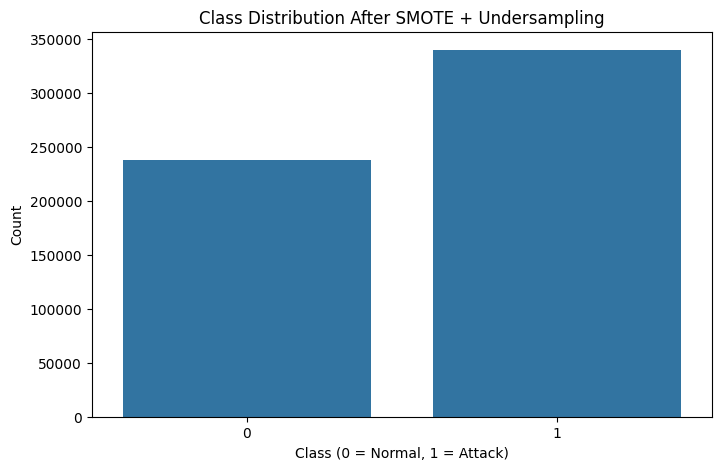

Class 0 (Normal) after balancing: 238045
Class 1 (Attack) after balancing: 340064


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Define a controlled balance ratio (avoid 50-50 split)
smote = SMOTE(sampling_strategy=0.6, random_state=42)  # Generate synthetic samples up to 60% of the majority class
undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Reduce the majority class slightly

# Apply oversampling (SMOTE) first, then undersampling
X_resampled, y_resampled = smote.fit_resample(X_scaled, df["Target"])
X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)

print("Class imbalance handled using SMOTE + undersampling.")

# Plot class distribution after balancing
plt.figure(figsize=(8, 5))
sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE + Undersampling")
plt.xlabel("Class (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.show()

# Print new class counts
class_counts_resampled = pd.Series(y_resampled).value_counts()
print(f"Class 0 (Normal) after balancing: {class_counts_resampled[0]}")
print(f"Class 1 (Attack) after balancing: {class_counts_resampled[1]}")


## Loading labeled and unlabeled test data.


In [ ]:
# URL for labeled test data
url_corrected = "http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz"

# Column names as per kddcup.names
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'Target'
]

# Load the labeled test dataset
df_test_labeled = pd.read_csv(url_corrected, names=column_names, compression='gzip', header=None)

In [ ]:
# URL for unlabeled test data (note: this file is not as commonly used, but mentioned on the site)
url_unlabeled = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.newtestdata_10_percent_unlabeled.gz"

# Unlabeled data has same columns except no "Target"
column_names_unlabeled = column_names[:-1]  # exclude "Target"

# Load the unlabeled test dataset
df_test_unlabeled = pd.read_csv(url_unlabeled, names=column_names_unlabeled, compression='gzip', header=None)


In [ ]:
def preprocess_test_set(df):
    df = df.copy()

    # 1. Encode categorical features using training-fitted encoders
    df['protocol_type'] = encoder_protocol.transform(df['protocol_type'])
    df['service'] = encoder_service.transform(df['service'])
    df['flag'] = encoder_flag.transform(df['flag'])

    # 2. Drop features removed during training
    df.drop(columns=low_variance_features, inplace=True, errors='ignore')
    df.drop(columns=high_corr_features, inplace=True, errors='ignore')

    # 3. Scale using MinMaxScaler fitted on training data
    df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

    return df_scaled


In [ ]:
print(df_test_labeled['protocol_type'].unique())
# Preprocess labeled test data
X_test_eval = preprocess_test_set(df_test_labeled.drop(columns=['Target']))
y_test_eval = df_test_labeled['Target']

# Preprocess unlabeled test data
X_test_unlabeled = preprocess_test_set(df_test_unlabeled)


['udp' 'tcp' 'icmp']


ValueError: invalid literal for int() with base 10: 'udp'

# 2. Model Development
#### First we need to split the data into Training Data and Testing Data.

In [ ]:
from sklearn.model_selection import train_test_split

# Display class distribution before splitting
print("Class Distribution BEFORE Splitting:")
print(y_resampled.value_counts())

# Perform Stratified Train-Test Split (Keeps Class Proportions Consistent)
x_train, x_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,           # 20% of data will be for testing
    stratify=y_resampled,    # Ensures balanced class proportions in train & test
    random_state=42          # For reproducibility
)

# Display class distribution after splitting
print("\nClass Distribution in Training Set:")
print(y_train.value_counts())

print("\nClass Distribution in Testing Set:")
print(y_test.value_counts())

#  Print dataset shapes
print("\nDataset Shapes:")
print(f" Training Data: {x_train.shape[0]} samples")
print(f" Testing Data: {x_test.shape[0]} samples")


Class Distribution BEFORE Splitting:
Target
1    340064
0    238045
Name: count, dtype: int64

Class Distribution in Training Set:
Target
1    272051
0    190436
Name: count, dtype: int64

Class Distribution in Testing Set:
Target
1    68013
0    47609
Name: count, dtype: int64

Dataset Shapes:
 Training Data: 462487 samples
 Testing Data: 115622 samples


## 2.1 Supervised Learning
### 2.1.1 Decision Trees
Using Training Data

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize Decision Tree with regularization
dt_model = DecisionTreeClassifier(
    max_depth=8,                # Prevents excessive depth (overfitting)
    min_samples_split=100,      # Requires 100 samples to split a node
    min_samples_leaf=50,        # Requires at least 50 samples per leaf
    ccp_alpha=0.1,             # Pruning to remove weak branches
    random_state=42
)

# Train the model
dt_model.fit(x_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(x_test)

# Evaluate model performance
print("Decision Tree Model Performance:")
print(classification_report(y_test, y_pred_dt))



Decision Tree Model Performance:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     47609
           1       0.91      0.99      0.95     68013

    accuracy                           0.94    115622
   macro avg       0.95      0.92      0.93    115622
weighted avg       0.94      0.94      0.94    115622



### 2.1.2 Random Forests

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

y_pred_rf = rf_model.predict(x_test)

print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))


Random Forest Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47609
           1       1.00      1.00      1.00     68013

    accuracy                           1.00    115622
   macro avg       1.00      1.00      1.00    115622
weighted avg       1.00      1.00      1.00    115622



Check if there is over-fitting.
*   If cross-validation accuracy drops, model is overfitting.
*   If it stays near 100%, then the dataset is probably easy to classify.




In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, x_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")


Cross-Validation Accuracy Scores: [0.99987027 0.99982702 0.99982702 0.99974053 0.99984864]
Mean CV Accuracy: 0.9998


### 2.1.3 Support Vector Machines (SVM)

In [ ]:
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)

y_pred_svm = svm_model.predict(x_test)

print("Support Vector Machine (SVM) Model Performance:")
print(classification_report(y_test, y_pred_svm))


2.1.4 Isolation Forest (UnSupervised Learning)

In [ ]:
# Train on only normal samples
normal_mask = y_train == 0
x_train_normal = x_train[normal_mask]

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.2,
    random_state=42
)
iso_forest.fit(x_train_normal)

# Predict on the test set
y_pred_iso = iso_forest.predict(x_test)
y_pred_iso_adjusted = np.where(y_pred_iso == 1, 0, 1)  # Matching the labels with 1 = 0 and -1 = 1

print("Isolation Forest Model Performance:")
print(classification_report(y_test, y_pred_iso_adjusted))

anomaly_ratio = sum(y_train) / len(y_train)
print(f"Anomaly proportion in training set: {anomaly_ratio:.2%}")

Isolation Forest Model Performance:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     47609
           1       0.87      1.00      0.93     68013

    accuracy                           0.91    115622
   macro avg       0.93      0.90      0.91    115622
weighted avg       0.92      0.91      0.91    115622

Anomaly proportion in training set: 58.82%
